# Introduction to Forecasting
<img src=images/logo.png align='right' width=200>

## Goal
While understanding the structure & dynamics of existent time series data (*interpolation*) is valuable, the main goal of time series analysis is most often *forecasting* - *extrapolation* of the current dynamics into the future. There are many competing techniques that can assist us with it. This will be the focus of this notebook.

## Program
- [Test Train Split](#tts)
- [Cross Validation and Grid Search](#cvgs)
    - [Assignment](#as1)
- [Choosing the right model](#crm)
- [Summary](#sum)

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

from sklego.preprocessing import RepeatingBasisFunction

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures

## The data

We go back to the previously seen *household power consumption* dataset for the rest of this notebook.

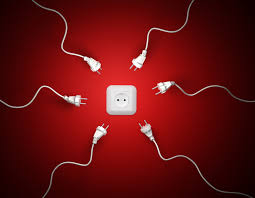

In [ ]:
power = pd.read_csv('data/household_power_consumption.csv', index_col='ts', parse_dates=True)

We shall forecast daily energy consumption.

We shall only focus on the days that had no missing values.

In [ ]:
power_daily = (
    power
    .assign(missing_data=lambda df: df['consumption'].isna())
    .resample('D')
    .agg({'consumption': sum, 'missing_data': any})
    .loc[lambda df: df['missing_data']!=True]
    .drop(columns='missing_data')
)
power_daily.head()

We can engineer some features to help our forecasting. We shall also add a smoothed version of our data that we can use for comparions.

In [ ]:
power_daily = (
    power_daily.loc['2007 Jul':]
    .assign(smoothed=lambda df: df['consumption'].ewm(alpha=0.05).mean(),
            period_num=lambda df: np.arange(len(df.index)),
            day_of_year=lambda df: df.index.dayofyear,
            day_of_week=lambda df: df.index.dayofweek,
            month=lambda df: df.index.month
           )
)
power_daily.head()

In [ ]:
power_daily[['consumption', 'smoothed']].plot(figsize=(18,4));

<a id='tts'></a>
## Test Train Split

Let's say we have a good forecasting model in mind. How do we actually evaluate its forecasting performance on time series data? In time series analysis, a special way of splitting the data into train and test parts is used:

<img src="images/train_test.png" style="width: 500px;"/>

A fraction of the most recent observations is held out from the model training. After fitting the model, we make predictions for the period of the test data. These predictions can then be compared with the actual values that we already know.

How large should the test set be? This depends on multiple factors:

- how much data we initially have
- which frequency does the data have
- how far into the future we want to forecast

Ideally, the test should be at least *as long as the maximum required forecasting horizon*. The 20% threshold, typically used in other applications, is therefore very situational in the case of time series. The longer the forecasting horizon, the more likely model predictions are to become inaccurate (as we predict based on other predictions).

In practice, test train split in time series is just indexing:

In [ ]:
train = power_daily.loc[:'2010 April']
test = power_daily.loc['2010 May':]

In [ ]:
fig, ax = plt.subplots(figsize=(18,6))
train['consumption'].plot(ax=ax)
test['consumption'].plot(ax=ax)
ax.legend(["train set", "test set"], prop={'size': 18});

Now suppose we have a good model and want to evaluate its forecasting potential in practice. We will proceed as follows:

- train this model on the train set
- make predictions for the duration of the test set
- compare these predictions with the actual data

The example below uses a linear model with the previously seen gradual seasonal filters

In [ ]:
X_train = train[['period_num','day_of_year']]
y_train = train['consumption']

In [ ]:
rbf = RepeatingBasisFunction(n_periods=12,
                             remainder='passthrough',
                             column='day_of_year')
model = Pipeline([
    ('preprocess', rbf),
    ('model', LinearRegression())
])

lm = model.fit(X_train, y_train)
power_daily['lm_pred'] = lm.predict(power_daily[['period_num','day_of_year']])

In [ ]:
fig, ax = plt.subplots(figsize=(18,6))
train[['consumption']].plot(ax=ax)
test[['consumption']].plot(ax=ax, c='g')
power_daily[['lm_pred']].plot(ax=ax, c='brown')
power_daily[['smoothed']].plot(ax=ax, c='orange')
ax.legend(["train set", "test set", "prediction", "weighted moving average"], prop={'size': 15});

These predictions look reasonable, but how good are they actually? In order to quantify a model's forecasting success, we need some evaluation metrics. We want to know how far off our predictions are on average.

We are predicting continuous values along a time series - therefore we need metrics suitable for this:

- Mean Absolute Error:   $$\frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|$$
- Mean Squared Error:   $$\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2$$
- Root Mean Square Error:   $$\sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$$

Let's evaluate our previous model:

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_test = test['consumption']
y_pred = power_daily['lm_pred'].loc['2010 May':]

MAE = round(mean_absolute_error(y_test, y_pred),2)
MSE = round(mean_squared_error(y_test, y_pred),2)
RMSE = round(np.sqrt(MSE),3)

print(f'MAE: {MAE}')
print(f'MSE: {MSE}')
print(f'RMSE: {RMSE}')

These metrics have their pros and cons. MSE & RMSE penalize larger errors more, while the MAE weighs all errors equally. MAE & RMSE (unlike MSE) have the same measurement units as the target variable, so the value of the error metric can be directly interpreted.

Judging if the error is too high is tricky and depends on the case. There are no really simple rules of thumb. 

It can therefore also be useful to compute the Mean Percentage Absolute Error: the average of percentage errors by which forecasts of a model differ from actual values of the quantity being forecast.

- Mean Percentage Absolute Error:   $$\frac{100\%}{n}\sum_{i=1}^{n}\frac{|y_i - \hat{y}_i|}{y_i}$$

Errors lower than 5-10% off that value are often seen as a sign of a well-fitted model.

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
MAPE = round(mean_absolute_percentage_error(y_test, y_pred)*100,2)
print(f'MAE: {MAE}, MAPE: {MAPE}%')

But how inaccurate is this model *actually*? What exactly do we want it to predict well? Should we punish it for missing days with power cuts or any other sources of extreme noises? Let's have a closer look at the test set predictions

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
test[['consumption']].plot(ax=ax, c='g')
power_daily[['lm_pred']].loc['2010 May':].plot(ax=ax, c='brown')
power_daily[['smoothed']].loc['2010 May':].plot(ax=ax, c='orange')
ax.legend(["test set", "prediction", "weighted moving average"], prop={'size': 11});

While our smooth model misses many sudden spikes, it is quite close to the weighted rolling average after September. If we want to select a model that is good at predicting average levels rather than individual spikes, we can also directly compare its predictions to the weighted rolling average.

Compared to the weighted rolling average the error levels of our model indeed look much more moderate.

In [ ]:
y_test_smoothed = test['smoothed']
y_pred = power_daily['lm_pred'].loc['2010 May':]

MAE = round(mean_absolute_error(y_test_smoothed, y_pred),2)
MSE = round(mean_squared_error(y_test_smoothed, y_pred),2)
RMSE = round(np.sqrt(MSE),3)
MAPE = round(mean_absolute_percentage_error(y_test_smoothed, y_pred)*100,2)

print(f'MAE: {MAE}, MAPE: {MAPE}%, RMSE: {RMSE}')

<a id='cvgs'></a>
## Cross Validation & Grid Search

Often we do not have a single favorite model, and instead there are multiple candidates or different variations of the same model. Ideally we want to compare them not just based on the predictions for the last few periods. This can easily lead to overfitting - just like a single train-test split with mainstream machine learning often would. A single test set in Time Series Analysis means that we are risking to select a model that is good at predicting these particular last periods, but not something somewhat different that may come afterwards.

One solution is *cross validation*. Instead of having a single test set, we can have multiple splits of the data to evaluate models. With time series however cross validation is more tricky due to the chain-like nature of time series. We can neither just select random combinations of timestamps, nor can we predict past points based on future points. There is nonetheless a way to perform cross validation:

<img src='images/cross_val.png' style="width:400px"></a> 

The idea is to split the whole time series into slices that always start from the very beginning but have different end points. Each slice is then divided into a training and testing parts, with the testing set always being the same length. The training parts are then used to train the model in each slice and are evaluated on the respective test sets.

Scikit-learn library has a special method for that called `TimeSeriesSplit`. After specifying our time series split, we can directly use it with *grid search* like we would in mainstream machine learning applications.


Here is how it works in practice:

In [ ]:
X_train = train[['period_num','day_of_year']]
y_train = train['consumption']

rbf = RepeatingBasisFunction(remainder='passthrough',
                             column='day_of_year')
model = Pipeline([
    ('preprocess', rbf),
    ('model', LinearRegression())
])

parameters = {
    'preprocess__n_periods':[4,6,12,24],
    'model__fit_intercept':[True, False]
}

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=3)

#print statement to explain the train/test split
for train_index, test_index in tscv.split(X_train):
    print(f"TRAIN: [{train_index.min(), train_index.max()}]", 
         f"TEST: [{test_index.min(), test_index.max()}]")

In [ ]:
from sklearn.model_selection import GridSearchCV
gsearch = GridSearchCV(estimator=model, cv=tscv,
                        param_grid=parameters, scoring='neg_root_mean_squared_error')

In [ ]:
gsearch.fit(X_train, y_train);
gsearch.best_estimator_.steps

In [ ]:
results = pd.DataFrame(gsearch.cv_results_)
results.sort_values('rank_test_score')

In [ ]:
power_daily['grid_pred'] = gsearch.predict(power_daily[['period_num','day_of_year']])

In [ ]:
power_daily.head()

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
test[['consumption']].plot(ax=ax, c='g')
power_daily[['grid_pred']].loc['2010 May':].plot(ax=ax, c='brown')
power_daily[['lm_pred']].loc['2010 May':].plot(ax=ax, c='blue')
power_daily[['smoothed']].loc['2010 May':].plot(ax=ax, c='orange')
ax.legend(["test set", "prediction gs-model", "prediction model", "weighted moving average"], prop={'size': 11});

In [ ]:
y_pred = power_daily['grid_pred'].loc['2010 May':]

MAE = round(mean_absolute_error(y_test_smoothed, y_pred),2)
MSE = round(mean_squared_error(y_test_smoothed, y_pred),2)
RMSE = round(np.sqrt(MSE),3)

print(f'MAE: {MAE}, MAPE: {MAPE}%, RMSE: {RMSE}')

<a id='as1'></a>
## Assignment

- experiment with the number of splits in *TimeSeriesSplit* and the scoring used in *GridSearch*, 
- observe whether this affects the results and our preferred model parameters and how
- what happens if the number of splits is set too low or too high?
- similarly, experiment with the set of parameters to choose from

An example solution is given below, where for different *n_splits* the RMSEs of the best model are determined.

In [ ]:
# %load answers/cv_splits.py


<a id='crm'></a>
## Choosing the right model

### ARIMA
**Autoregressive integrated moving average**.
Learning about the future from recent past: variable of interest is regressed on its own lagged values. Designed for stockmarket predictions.

**Pros:** 
- Can provide quite accurate short-term forecast if the data is substantially autocorrelated

**Cons:** 
- Requires careful tuning and insufficient tuning can lead to a poor model. 
- Requires stationary time series: a time series whose properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. 
- Hard to interpret and break into quantifiable effects.

---

### LSTMs
**Long short term memory neural networks**. Combine NN's flexibility with keeping track of the recent and distant past (memory cells)

**Pros:** 
- Flexible and does not require much preprocessing and parameter tuning. 
- Can exploit complex dependencies in time series

**Cons:** 
- Prone to over-fitting. 
- Training requires large datasets. 
- Even harder to interpret than ARIMA

---

### Prophet
Forecasting time series data by explicitly modeling trends, seasonalities and holiday effects - especially suitable for business applications.

**Pros:** 
- Highly automated and simple to use. 
- Does not require extensive preprocessing and domain knowledge. 
- Robust to missing data, outliers and dramatic changes. 
- Measures explainable and quantifiable effects. 
- Can be easily used to detect outliers and trend change points. 
- Typically outperforms many custom models.

**Cons:** 
- Is a bit of a black box. 
- Still in development and some features are still missing. 
- Less customization of the model.

<a id='sum'></a>
## Summary

We have covered: 

- How to forecast and evaluate predictions.
- How to conduct a hyperparameter grid search for forecasting.
- The advantages/disadvantages of popular forecasting models.